In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv("weatherAUS_clean.csv")
print(df.shape)
df.head()

(123710, 31)


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,spring,summer,autumn,winterRain,springRain,summerRain,autumnRain,latitude,longitude,RainTomorrow
0,13.4,22.9,0.6,4.8,8.6,44.0,20.0,24.0,71.0,22.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0
1,7.4,25.1,0.0,4.8,8.6,44.0,4.0,22.0,44.0,25.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0
2,12.9,25.7,0.0,4.8,8.6,46.0,19.0,26.0,38.0,30.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0
3,9.2,28.0,0.0,4.8,8.6,24.0,11.0,9.0,45.0,16.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0
4,17.5,32.3,1.0,4.8,8.6,41.0,7.0,20.0,82.0,33.0,...,False,False,False,False,False,False,False,-36.080477,146.91628,0


In [6]:
df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Year', 'Month', 'Day', 'winter',
       'spring', 'summer', 'autumn', 'winterRain', 'springRain', 'summerRain',
       'autumnRain', 'latitude', 'longitude', 'RainTomorrow'],
      dtype='object')

In [7]:
target = "RainTomorrow"
features = ['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'Year',
 'Month',
 'Day',
 'winter',
 'spring',
 'summer',
 'autumn',
 'winterRain',
 'springRain',
 'summerRain',
 'autumnRain']


In [8]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

# Przygotujmy wrapper - na końcu pojawiają się *args i **kwargs - listy parametrów podawane w postaci słownika
# lub listy.
def CVTestSVM(nFolds = 5, randomState=2020, debug=False, sampleSize = 5000, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy na wyniki:
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = SVC(probability=True, max_iter=-1, random_state=2020, tol=0.001, cache_size=500, *args, **kwargs)
        # Wyświetlenie wywołania funkcji
        if debug:
            print(clf)
        #Zmniejszenie zbioru treningowego
        sampleSize = sampleSize
        X = df.iloc[train].sample(sampleSize)
        # Trenowanie modelu
        clf.fit(X[features], X[target])

        # Przygotowanie prognoz dla zbioru traeningowego i testowego
        # UWAGA Sklearn zwracałbędzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie statystyka lda każdego foldu
        trainScore = roc_auc_score((df[target].iloc[train]).astype(int), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]).astype(int), preds)
        
        # Zapisanie wyników do list
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices


In [9]:
trainResults, testResults, predictions, indices = CVTestSVM(nFolds = 5, randomState=2020)
print(np.mean(trainResults), np.mean(testResults))

0.8532941348284953 0.8532869369041295


In [10]:
resultSVM = {
    "name":"SVM",
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

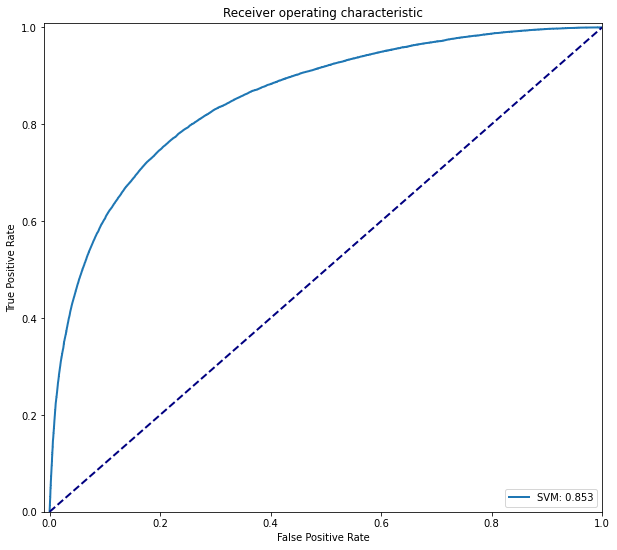

In [11]:
res2plot = []
true = (df[target]).astype(int).sort_index()
for result in [resultSVM]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))

from helpers import plotROCs
plotROCs(res2plot)

In [12]:
import pickle

# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("result_SVM.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(resultSVM, fp)